# Training

First, lets import the classes you defined in the previous parts:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
%load_ext autoreload
%autoreload 2
from model import Model
from dataset import CellsDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we will again read the csv with the cells' locations and filter cells on the borders:

In [15]:
data = pd.read_csv("cells_locations.csv", index_col=0)

In [16]:
size_px = 60
image_size = 2048
data = data[(data["centroid-0"] > size_px) & (data["centroid-0"] < (image_size-size_px))]
data = data[(data["centroid-1"] > size_px) & (data["centroid-1"] < (image_size-size_px))]

Split the dataset to training, validation and testing sets:

In [17]:
images = data.image_id.unique()
images_train = images[:9]
images_val = images[9:14]
images_test = images[14:]
data_train = data[data["image_id"].isin(images_train)]
data_val = data[data["image_id"].isin(images_val)]
data_test = data[data["image_id"].isin(images_test)]

Note that in the code above we added a validation set, it's a common practice in machine learning. 
We are training the model on the training set, making sure the model has good results and converge on the validation set. (On this set we'll also tune the hyper parameters).
Then the final testing of the model will be on the testing set. It's done to ensure that we are not overfitting the test. And that we will eventually have good results on an unseen test.

## Part 3: Training the model

Now we are going to train the model. The basic componnent of most training optimization are:
<div>
<ul>
    <li><b>Model</b> - The model we are trying to optimize, this would be the CNN model we defined in previous sections</li>
    <li><b>Dataset and Dataloader</b> - As outlined in previous sections, the DataLoader will allow us to iterate through the data in batches</li>
    <li><b>Loss function</b> - The function we are trying to optimize. The main concept of training the neural network is adjusting the model's weights in a direction that decrease the overall loss across all the data. Lower values signify better performance in the task.
<br>&ensp;&ensp;For example, in the task of image reconstraction one possible loss metric could be MSE, the MSE calculate the mean squared error between the real image and the reconstructed image. We want to find the weights that will give us minimum value for this loss. 
<br>&ensp;&ensp;In our case we have a classification task (involving multiple classes). The most commonly used loss is <b>CrossEntropyLoss</b>. 
<br> With CrossEntropyLoss we want to get <b>high probabilities for the correct class</b>. Essentially, the loss will be <b>-log(p)</b> where p stands for the probability of belonging to the correct class. 
<br> A high p corresponds to a low loss, while a low p leads to a high loss</li>
    <li><b>Optimizer</b> - like many optimization problem we need to define the method in which the weights of our model will be optimized. The most known one is <b>SGD</b>. Other common method is <b>Adam</b>. <br> Those optimization methods are gradients based.</li>
</ul>
</div>

This was just a brief explanation, You're encouraged to explore the mathematical rationale behind it. In the first section, you were presented with a few good sources for learning it.

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 
Fill in the code below, according to the comments. For each comment you should only write 1-2 lines of code.

You can go over this link for help if needed:
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [18]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
from torch import nn
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Subset

In [19]:
device = "cuda"

In [20]:
#Define the model assuming you have 15 (+1 for the unidentified class we added) classes and 25 channels + 1 channel of segmentation:
num_channels = 25 + 1
class_num = 15 + 1
model = Model(num_channels, class_num)

# >> Change state of model to "cuda", so the calculationg will run on the GPU:
model = model.to(device)
# >> Change state of model to "train", check online what does it mean:
model.train()
# >> Define an optimizer, keep the defualt parameters:
optimizer = optim.Adam(model.parameters())
# >> Define the training and validation datasets
path = "/home/projects/aihubadm/aihub_shared/ex-cell-classification/Multiplexed_Images"
train_dataset = CellsDataset(data_train,path)
val_dataset = CellsDataset(data_val,path)
# >> Define the loss function, it should be CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()

<div style="font-size: 20px;color:green;background:#D3D3D3"> &#187; Checking for understanding, Answer the following: </div> 

- What does model.train() do? look online to find the answer.
- What will model.eval() do?

### Balancing the classes in the dataset

Some datasets are highly un-balanced, for example this dataset. You'll notice that some cell types consist of only a few hunderds of cells while other cell types consist thousands of cells.
For further investigation:
<br>&ensp;&ensp; - Calculate the cell types distribution
<br>&ensp;&ensp; - What do you see? What are the common cell types?
<br>&ensp;&ensp; - Balance the dataset so that in each batch the model will see equal proportion of each cell type. (check "WeightedRandomSampler" from pytorch, note that it's expecting to get the weights for each sample and not the weights of each class)

Note that it'll require you to also define the trainloader here.

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 

In [21]:
# Wite code Here

<Axes: >

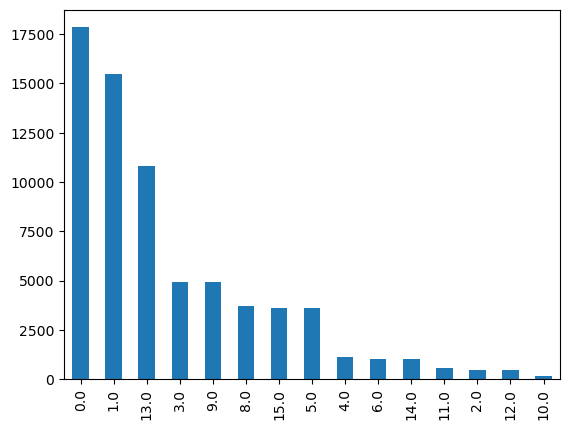

In [22]:
labels = [train_dataset[i][2] for i in range(len(train_dataset))]
value_counts = pd.Series(labels).value_counts()
value_counts.plot(kind='bar') 

In [23]:
label_counts = Counter(labels)
weights = [1.0 / label_counts[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
train_loader = DataLoader(train_dataset, 
                          batch_size=32,
                          num_workers=4,
                          shuffle=False,sampler=sampler)

We'll now test that during one pass over the data we get approximately equal proportion of each cell type.

In [24]:
labels = []
for _, _, label in tqdm(train_loader):
    labels += label.tolist()
labels = np.array(labels)
_, count_unique = np.unique(labels, return_counts=True)
np.testing.assert_allclose(count_unique - count_unique.mean(), np.zeros_like(count_unique), atol=200)

100%|██████████| 2182/2182 [00:33<00:00, 65.48it/s]


<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 
Define the validation Dataloader here:

In [25]:
val_loader = DataLoader(val_dataset,
                          batch_size=32,
                          num_workers=4,
                          shuffle=False)

## Training the model

As you may recall, we've split the data to: train, validation and test. The training loop iterates over the training data to optimize the model accordingly. <br>
For each training epoch, we want to evaluate the model on the validation set and record the validation loss. This will allow us to monitor the training process and make ensure that we are not overfitting the training set. <br>
In the next section you will first implement the training loop.
Afterward you will implement the validation step. <br>
Finally you will train and observe the model by comparing the training and validation loss in each epoch.

### The training loop

Now we will create the training loop, for each epoch we want to iterate over the whole dataset and update the weights of the model.
In general one iteration over a batch will have the following steps:
- Zero the gradients (from previous iterations)
- Prepare the input for the network: you should concatenate the protein channels with the segmentation channel.
- Run the model 
- Calculate the loss
- Propogate the gradients back from the loss back thourgh the model.
- Do one step of optimization based on the gradient pytorch calculate for us.

A few notes before you start:
*   Make sure to run on cuda to save time
*   Note that the first channel in the input should be the channels for the model.
*   You might want to save your model so you can reload it after training, see more here: https://pytorch.org/tutorials/beginner/saving_loading_models.html
*   <b>A basic technique for debugging deep learning code is attempting to overfit your training data. To achieve this, you should train on small, consistent subset of your data for multiple epochs. Ensure that the loss decrease and that accuracy reaches high values. Begin with attempting to overfit on just 10 to 100 cells.</b>

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 
Fill in the function below, according to the comments. For each comment you should only write 1-2 lines of code.

In [32]:
def training_loop(model, train_loader):
    train_losses = []
    model.train() #Notice we are changing the model state to train mode.
    for i, batch in enumerate(train_loader):
        imgs, seg, gts = batch
        imgs = imgs.to(device=device)
        gts = gts.to(device=device).long()
        imgs = torch.moveaxis(imgs, -1, 1).float().to(device=device) # Matching the order of the axes from the DataLoader to the model's expectations.
               
        #>> Prepare the input to the model
        seg = seg[:, None, :, :].to(device=device)
        inputs = torch.cat((imgs, seg), dim=1)
        # >> Zero the gradients of the optimizer
        optimizer.zero_grad()
        
        # >> Run the model on the imgs
        model = model.to(device = device)
        outputs = model(inputs)
        
        # >> Calculate the loss
        loss = criterion(outputs,gts)
        
        # >> Append the training loss to the train_losses
        train_losses.append(loss.item())

        # >> Propogate back the gradients from the loss to the input
        loss.backward()

        # >> Apply one step of optimization the oprimixation function.  
        optimizer.step()
        
    return np.mean(train_losses)

### The validation step

Now we will implement the validation step, for each epoch we want to iterate over the whole validation dataset and calculate the loss of the dataset, without optimizing the model. we just want to measure how good the model generalize.

A few notes before you start:
*   Make sure to run on cuda to save time
*   Note that the first channel in the input should be the channels for the model.
*   Remember to use "with torch.no_grad():" before running the model in order to make the calculation more efficient. When we are evaluating the model there is no need to keep track of the gradients, <a href="https://pytorch.org/docs/stable/generated/torch.no_grad.html">See doc</a>.

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 
Fill in the function below, according to the comments. For each comment you should only write 1-2 lines of code.

In [33]:
def validation_step(model, val_loader):
    model.eval() #Notice we are changing the model state to eval mode.
    val_losses = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            imgs, seg, gts = batch
            imgs = imgs.to(device=device)
            gts = gts.to(device=device).long()
            imgs = torch.moveaxis(imgs, -1, 1).float().to(device=device)
            seg = seg[:, None, :, :].to(device=device)
            #>> Prepare the input to the model
            inputs = torch.cat((imgs, seg), dim=1)

            # >> Run the model on the batch with no_softmax=True
            outputs = model(inputs,no_softmax=True)

            # >> Calculate the validation loss and append it to val_losses
            loss = criterion(outputs,gts)
            val_losses.append(loss.item())

        return np.mean(val_losses)

### The whole training and validation process:
Finally, we'll integrate the training loop and the validation step so that after each training epoch, we perform one evaluation pass on the validation set.
 <br>
Make sure to present the validation loss as well as the training loss on the lossplot.

In [34]:
import tqdm
from livelossplot import PlotLosses

In [35]:
epochs = 10
device = "cuda"

In [ ]:
from torchvision import transforms
#Relevant only for part6
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(10),
])

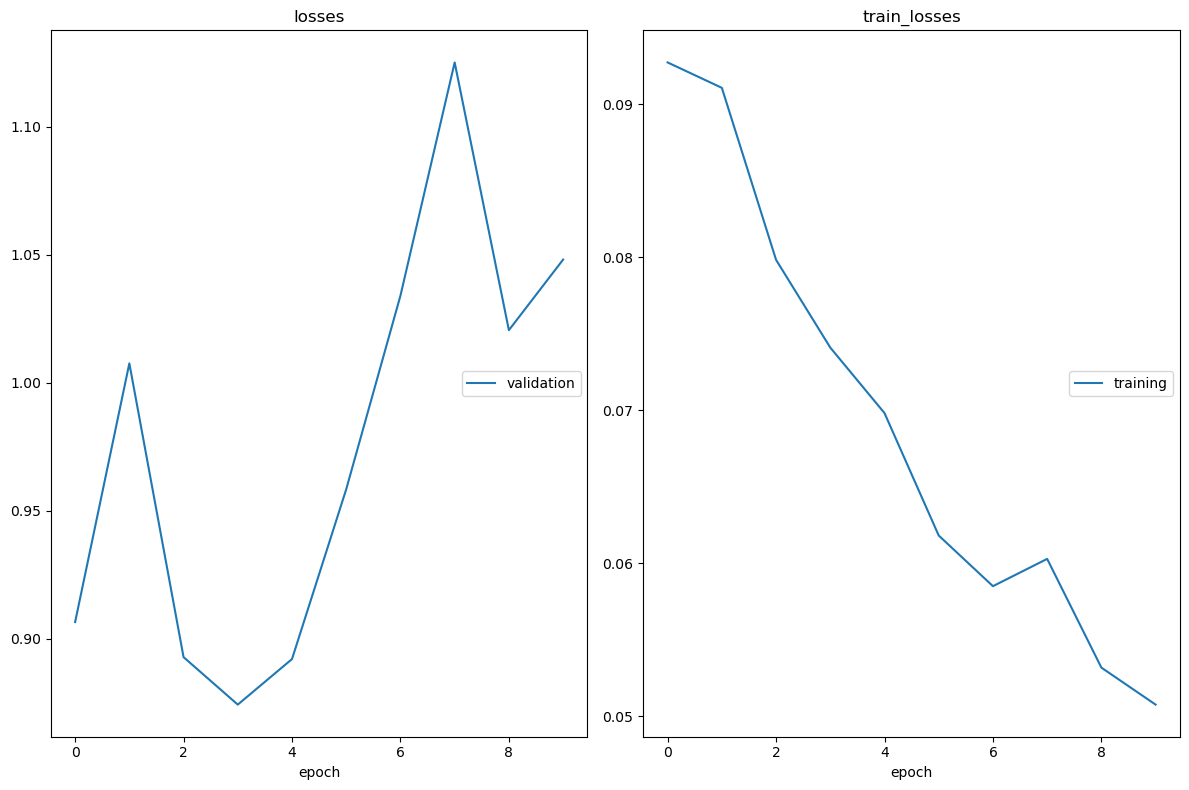

100%|██████████| 10/10 [16:09<00:00, 96.99s/it]

losses
	validation       	 (min:    0.874, max:    1.125, cur:    1.048)
train_losses
	training         	 (min:    0.051, max:    0.093, cur:    0.051)


In [39]:
liveloss = PlotLosses()
for e in tqdm.tqdm(range(epochs)):
    train_loss_avg = training_loop(model, train_loader)
    val_loss_avg = validation_step(model, val_loader)
    torch.save(model.state_dict(), f"checkpoint_weights_{e}.pth")

    liveloss.update({"train_losses": train_loss_avg,
                "val_losses": val_loss_avg})
    liveloss.draw()

In [52]:
def aug_training_loop(model, train_loader, augmentations):
    train_losses = []
    model.train()  # Set the model to train mode.
    for i, batch in enumerate(train_loader):
        imgs, seg, gts = batch
        # Apply augmentations
        imgs = torch.stack([augmentations(img) for img in imgs])  # Apply the augmentations
        
        imgs = imgs.to(device=device)
        gts = gts.to(device=device).long()
        imgs = torch.moveaxis(imgs, -1, 1).float().to(device=device)  # Matching axis order
        # Prepare the input to the model
        seg = seg[:, None, :, :].to(device=device)
        inputs = torch.cat((imgs, seg), dim=1)
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        # Run the model on the imgs
        model = model.to(device=device)
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, gts)
        # Append the training loss
        train_losses.append(loss.item())
        # Backpropagate the gradients
        loss.backward()
        # Perform an optimization step
        optimizer.step()
        
    return np.mean(train_losses)

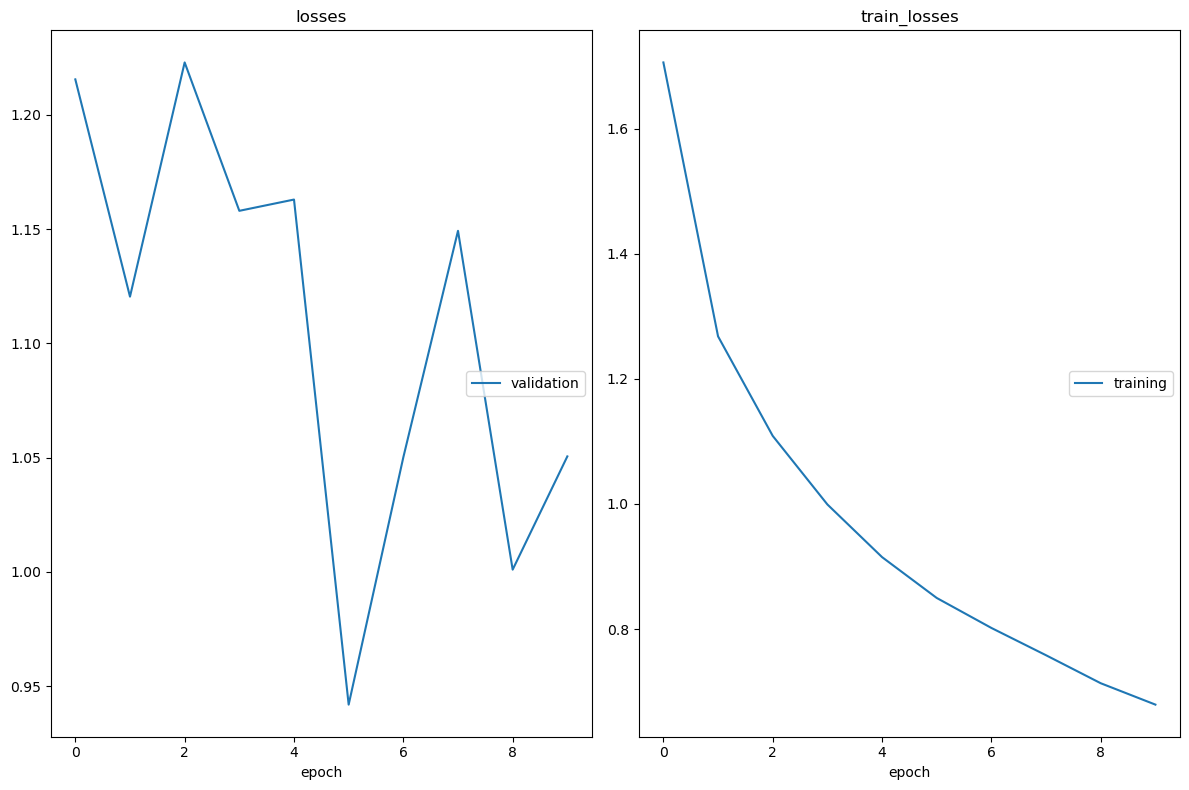

100%|██████████| 10/10 [38:50<00:00, 233.01s/it]

losses
	validation       	 (min:    0.942, max:    1.223, cur:    1.051)
train_losses
	training         	 (min:    0.679, max:    1.706, cur:    0.679)


In [53]:
import torch
liveloss = PlotLosses()
for e in tqdm.tqdm(range(epochs)):
    train_loss_avg = aug_training_loop(model, train_loader,augmentations)
    val_loss_avg = validation_step(model, val_loader)
    print(train_loss_avg)
    print(val_loss_avg)
    torch.save(model.state_dict(), f"checkpoint_weights_{e}.pth")

    liveloss.update({"train_losses": train_loss_avg,
                "val_losses": val_loss_avg})
    liveloss.draw()


Keep track of the losse's values above. Train for at least 10 epochs.
<div style="font-size: 20px;color:green;background:#D3D3D3"> &#187; Checking for understanding, Answer the following: </div> 

- Did you managed to overfit on the small subset from the training set? 
- Describe the bahvior of the training and validation loss as you overfit on increaing training set, is it as expected?
- What impact does the learning rate have? Try various values and observe the change in the loss behavior.
- What do you think will be the impact of changing the batch size?
- How will you choose the stopping epoch for trainings? Can you recognize the point of overfitting?

<div style="font-size: 20px;color:blue;background:#D3D3D3"> &#187; Important! </div> 

Running on the whole dataset for 10 epochs should take around 15 minutes, you can definitely train your own model but if you want you can load the pretrained model from "checkpoint.pth" so you wouldn't have to wait for training on the whole dataset.

## Part 4: Evaluate the model

We now aim to assess our model's performance on the test set. The motivation for this step is to asses how well our model generalizes to unseen data. <br> In order to be unbiased, we've selected a test set originating from different images than the training data. <br>
In the next section, we will define metrics for evaluating the model. However, in this section, we are just going to loop over the test set and record the predictions provided by the model.

Let's start by creating a DataLoader for the test set.

In [54]:
test_dataset = CellsDataset(data_test,path)
test_loader = DataLoader(test_dataset, 
                          batch_size=32,
                          num_workers=2,
                          shuffle=False)

Let's load a model that was trained with the complete training set:

In [55]:
#Load weights from checkpoint.pth
model.load_state_dict(torch.load("checkpoint_weights_9.pth"))

<All keys matched successfully>

Change the state of the model to eval:
<br>
<i>(The <b>;</b> is  here just to prevent the function from printing to the notebook)</i>

In [56]:
model.eval();

<div style="font-size: 20px;color:red;background:#D3D3D3"> &#187; Coding Task! </div> 

Now we'll loop over the DataLoader and apply the model. <br>
Change the code below and accumulate the gts and the predictions in each iteration, save them as two lists, in the following cell we'll create a DataFrame out of those lists:

Remember to use "with torch.no_grad():" before running the model in order to make the calculation more efficient. 
When we are evaluating the model there is no need to keep track of the gradients, <a href="https://pytorch.org/docs/stable/generated/torch.no_grad.html">See doc</a>.

In [57]:
gts_total = []
preds_total = []
for i, batch in enumerate(test_loader):
    imgs,seg, gts = batch
    imgs = imgs.to(device=device)
    imgs = torch.moveaxis(imgs, -1, 1).float()
    gts = gts.to(device=device).long()
    #>> Prepare the input to the model
    seg = seg[:, None, :, :].to(device=device)
    inputs = torch.cat((imgs, seg), dim=1)
    # >> Run the model and keep the gts and predictions
    preds = model(inputs,no_softmax=True)
    
    gts_total += gts.flatten().tolist()
    preds_total += preds.argmax(axis=1).flatten().tolist()

In [58]:
results = pd.DataFrame({"gts": gts_total, "preds": preds_total})

Save the results for the next part:

In [59]:
results.to_csv("results.csv")

In the next sections, we will measure the model's performance!